# Notatblokk for å lage profiler fra DTM
Dei øverste celler er import av nødvendige python blioteker og hjelpefunksjoner for å plotte ut profiler. Disse må kjøres først for å kunne generere plott

In [7]:
import arcpy
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline

In [9]:
def profil(inputfc, insurface, out_table):
    '''Funksjonen lager pandas dataframe fra ein feature i ein arcgis geodatabase'''
    arcpy.ddd.StackProfile(inputfc, insurface, out_table)
    with arcpy.da.SearchCursor(out_table, ["FIRST_DIST", 'FIRST_Z']) as cursor:
        m_list = []
        z_list = []
        
        for row in cursor:
            m, z = row
            m_list.append(m)
            z_list.append(z)
              
        #Etablerer Pandas dataframe for forenkling av vidare databehandling
    df = pd.DataFrame(list(zip(m_list, z_list)), columns =['M', 'Z'])
    return df


def fargeplot(df, rutenettx, rutenetty, farger='Snøskred', aspect=1, tiltak=False, tiltak_plassering=0,
              femtenlinje=False, linjeverdi=1/15, meterverdi=0, retning='Mot venstre',
              justering=0, legend=True, vannflate=False, kote=0, vann_retning='Mot høgre'):
    """Funksjonen setter opp pyplot og plotter medst.plot()
    
    TODO: Berre returne fig og ax fra matplotlib og ta ut st.pyplot() fra funksjonen
    """

    xy = df[['M', 'Z']].to_numpy()
    xy = xy.reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])
    if femtenlinje:
        femten = ein_paa_femten(df, meterverdi, linjeverdi, retning, justering)
    if vannflate:
        vannlinje = vann(df, kote, vann_retning)
    if tiltak:
        tiltak_punkt = vis_tiltak(df, tiltak_plassering)

    #TODO: Ta ut fargemapping frå funksjonen
    if farger == 'Snøskred':
        cmap = ListedColormap(['grey', 'green', 'yellow', 'orange', 'orangered', 'red', 'darkred'])
        norm = BoundaryNorm([0, 27, 30, 35, 40, 45, 50, 90], cmap.N)
        legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='0 - 27\N{DEGREE SIGN}',
                        markerfacecolor='grey', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='27-30\N{DEGREE SIGN}',
                        markerfacecolor='green', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='30-35\N{DEGREE SIGN}',
                        markerfacecolor='yellow', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='35-40\N{DEGREE SIGN}',
                        markerfacecolor='orange', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='40-45\N{DEGREE SIGN}',
                        markerfacecolor='orangered', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='45-50\N{DEGREE SIGN}',
                        markerfacecolor='darkred', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='50-90\N{DEGREE SIGN}',
                        markerfacecolor='black', markersize=15),
        ]
    if farger == 'Jordskred':
        cmap = ListedColormap(['grey', 'palegreen', 'green', 'greenyellow', 'orange', 'orangered', 'darkred'])
        norm = BoundaryNorm([0, 3, 10, 15, 25, 45, 50, 90], cmap.N)
        legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='0 - 3\N{DEGREE SIGN}',
                markerfacecolor='grey', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='3-10\N{DEGREE SIGN}',
                markerfacecolor='palegreen', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='10-15\N{DEGREE SIGN}',
                markerfacecolor='green', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='15-25\N{DEGREE SIGN}',
                markerfacecolor='greenyellow', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='25-45\N{DEGREE SIGN}',
                markerfacecolor='orange', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='45-50\N{DEGREE SIGN}',
                markerfacecolor='orangered', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='50-90\N{DEGREE SIGN}',
                markerfacecolor='darkred', markersize=15),
        ]
    if farger == 'Stabilitet':
        cmap = ListedColormap(['blue','aquamarine' , 'lime', 'green','yellow', 'orange', 'orangered', 'red', 'black']) #8
        norm = BoundaryNorm([0, 2.9, 3.8, 5.7, 14, 26.6, 33.7, 45, 63.4, 90], cmap.N) 
        legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='< 1:20',
                markerfacecolor='blue', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:20 - 1:15',
                markerfacecolor='aquamarine', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:15 - 1:10',
                markerfacecolor='lime', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:10 - 1:4',
                markerfacecolor='green', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:4 - 1:2',
                markerfacecolor='yellow', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:2 - 1:1.5',
                markerfacecolor='orange', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:1.5 - 1:1',
                markerfacecolor='orangered', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='1:1 - 3:1',
                markerfacecolor='red', markersize=15),
            Line2D([0], [0], marker='o', color='w', label='> 3:1',
                markerfacecolor='black', markersize=15)
        ]

    #TODO: Gå vekk fra fastsatt bredde på plot?
    fig, ax = plt.subplots(figsize=(15,10))
    coll = LineCollection(segments, cmap=cmap, norm=norm)
    coll.set_array(df.Vinkel)
    coll.set_linewidth(3)
    #fig.figimage(img, 100, 50, alpha=0.25)
    ax.add_collection(coll)
    ax.autoscale_view()

    #Lar bruker justere inn avstand mellom rutenettet
    ax.set_yticks(np.arange(0,df['Z'].max(),rutenetty))
    ax.set_xticks(np.arange(0,df['M'].max(),rutenettx))
    ax.grid(linestyle = '--', linewidth = 0.5)

    #TODO: Ta inn brukerstyrt labeling?
    ax.set_ylabel('Høgde (moh.)')
    ax.set_xlabel(f'Lengde (m) | Høgdeforhold: {aspect}:1')
    ax.set_aspect(aspect, 'box')

    #Brukes til å styre presentasjon av plotting
    høgdeforskjell = df['Z'].max() - df['Z'].min()
    ax.set_ylim(df['Z'].min() - høgdeforskjell/10, df['Z'].max() + høgdeforskjell/10)

    if tiltak:
        ax.scatter(tiltak_punkt[0], tiltak_punkt[1], marker='x', s=200, color='black', linewidths=3, zorder=10)
    if femtenlinje:
        ax.plot(femten[0], femten[1], color='green', label='1:15', linestyle='dashed')
        ax.annotate(f'Helling: 1:{round(1/linjeverdi, 1)}', (femten[0][0], femten[1][0]), textcoords="offset points", xytext=(10, 10), ha='center', color='green')
    if vannflate:
        ax.plot(vannlinje[0], vannlinje[1], color='blue', label='1:15', linestyle='dashed')
    if legend:
        ax.legend(handles=legend_elements, title='Tegnforklaring')
    return

def vis_tiltak(df, meterverdi):
    """Henter ut M og Z verdi for plotting basert på M verdi"""
    radnr = df['M'].sub(meterverdi).abs().idxmin()
    M = float(df.iloc[radnr]['M'])
    Z = float(df.iloc[radnr]['Z'])
    return M, Z


def ein_paa_femten(df, meterverdi, linjeverdi=1/15, retning='Mot venstre', justering=0):
    """Lager lister (x verier, og y verdier) for 1:15 linje
    
    Tar utganspunkt i eit startpunkt, meterverdi, og retning
    Justering brukes for å senke startpunkt for linje under terreng
    """
    radnr = df['M'].sub(meterverdi).abs().idxmin()
    M = float(df.iloc[radnr]['M'])
    Z = float(df.iloc[radnr]['Z']) - justering
    M_max = float(df['M'].max())
    liste_x = []
    liste_y = []
    liste_x.append(M)
    liste_y.append(Z)
    if retning == 'Mot venstre':
        liste_x.append(0)
        liste_y.append(Z + M*(linjeverdi))
    if retning == 'Mot høgre':
        liste_x.append(M_max)
        liste_y.append(Z + (M_max-M)*(linjeverdi))
    
    return liste_x, liste_y

def vann(df, kote, retning='Mot høgre'):
    """Lager lister (x verier, og y verdier) for ei linje med vilårlig vinkel
    
    Tar utganspunkt i eit startpunkt, meterverdi, og retning
    Justering brukes for å senke startpunkt for linje under terreng
    """
    linjeverdi = 0
    radnr = df['Z'].sub(kote).abs().idxmin()
    M = float(df.iloc[radnr]['M'])
    Z = float(df.iloc[radnr]['Z'])
    M_max = float(df['M'].max())
    liste_x = []
    liste_y = []
    liste_x.append(M)
    liste_y.append(Z)
    if retning == 'Mot venstre':
        liste_x.append(0)
        liste_y.append(Z + M*(linjeverdi))
    if retning == 'Mot høgre':
        liste_x.append(M_max)
        liste_y.append(Z + (M_max-M)*(linjeverdi))
    
    return liste_x, liste_y


def terrengprofil(df, utjamning=False, opplosning=None):
    """Tar inn ein dataframe og regner ut hellinger og vinkler

    Dataframe må ha formatet, X, Y, Z, M
    Utjamning kan settes til True, men da må også oppløsning gis
    Denne 
    """
    if utjamning == True:
        df = df.groupby(np.arange(len(df))//opplosning).mean()
    
    #Rekner ut hellinger, litt uelegant utanfor pandas, men funker..
    z = df['Z'].tolist()
    m = df['M'].tolist()
    h = []
    
    for i in range(len(z)):
        h.append((z[i] - z[i -1])/(m[i] - m[i - 1])) 

    df['Helning'] = h
    df['Vinkel'] = abs(np.degrees(np.arctan(df['Helning'])))

    return df

# Input kjem i cellen under her

In [16]:
#Gi inn sti til geodatabasen der f.eks profillinjer ligeger
gdb = r'C:\Users\janaal\Documents\ArcGIS\Projects\Voss\Voss.gdb'

#Gi inn stil til DTM som skal bruker
insurface1 = r'C:\Users\janaal\Documents\ArcGIS\Projects\Terrengprofil\Sogndal_Aurland_Lærdal 2014\data\dtm\Sogndal_Aurland_Lærdal 2014-33-1-436-165-61-dtm.tif'


# Generelt oppsett

In [14]:
#Rutenett i plot
ruteavstand_x = 10
ruteavstand_y = 10

#Dersom høgde skal overdrivast i profilet kan aspect endres
aspect = 1

# Generering av eit profil

In [17]:
tittel = 'Profil 1'
farger = 'Stabilitet'  #Kan være 'Snøskred', 'Jordskred' eller 'Stabilitet'. Gir forskjellig fargeskala for bratthet langs profilet
featurenavn = 'Profil'

'''Alt under her er tilleggsvalg som kan gi meir info på plott, sjå demo lenger ned'''
utjamning = False #Dersom ein vil forenkle profilet, f.eks ved bruk av veldig fin DTM kan ein få det på meterskala eller f.eks 10 meter per punkt
opplosning = 1
tiltak = False #Dersom ein vil plotte plassering av eit tiltak, kjem opp som kryss, skriv True om du vil ha det med
tiltak_plassering = 35 #Plasseringen av tiltaket, meterverdi langs profilet, høgde kjem automatisk
femtenlinje = True #Legger på ei linje langs profilet med fast helling
linjeverdi = 1/1  #Hellinga på linja
meterverdi = 24 #Start på linja
retning ='Mot venstre'  #retning på linje med helling
juster = 0 #Høgdejustering i forhold til profillinja
legend=True #Vise tegnforklaring eller ikkje, skriv False hvis ikkje
vannflate=False #Vise vannflate eller ikkje, gir ei horisontal linje på valgt kote
kote=44 #Kote på vannflate
vann_retning="Mot høgre" #Retning på horisontal strek

inputfc1 = gdb + '\\' + featurenavn
out_table1 = "temp_tabell" + str(time.time())[-4:]
df = profil(inputfc1, insurface1, out_table1)
df_plot = terrengprofil(df, utjamning, opplosning)
fargeplot(df_plot, ruteavstand_x, ruteavstand_y, farger, aspect, tiltak, tiltak_plassering, femtenlinje, linjeverdi, meterverdi, retning, juster, legend, vannflate, kote, vann_retning)
plt.title(tittel)
arcpy.management.Delete(gdb + '\\' + out_table1)

TypeError: reduction operation 'argmin' not allowed for this dtype

<Result 'true'>

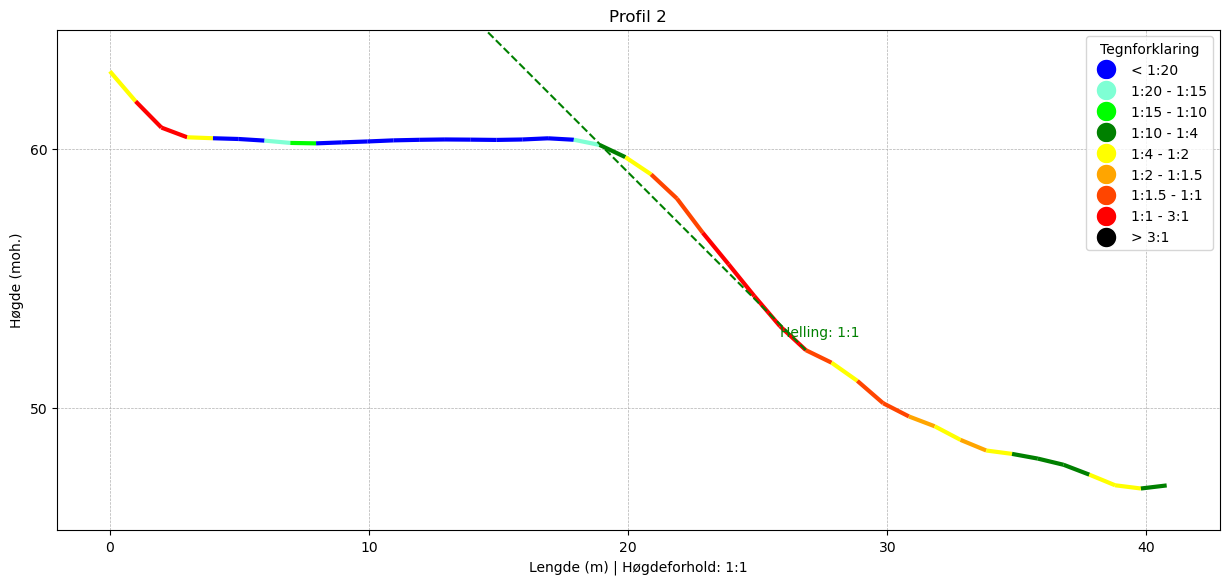

In [48]:
tittel = 'Profil 2'
farger = 'Stabilitet'  #Kan være 'Snøskred', 'Jordskred' eller 'Stabilitet'. Gir forskjellig fargeskala for bratthet langs profilet
featurenavn = 'Profil2'

'''Alt under her er tilleggsvalg som kan gi meir info på plott, sjå demo lenger ned'''
utjamning = False #Dersom ein vil forenkle profilet, f.eks ved bruk av veldig fin DTM kan ein få det på meterskala eller f.eks 10 meter per punkt
opplosning = 1
tiltak = False #Dersom ein vil plotte plassering av eit tiltak, kjem opp som kryss, skriv True om du vil ha det med
tiltak_plassering = 35 #Plasseringen av tiltaket, meterverdi langs profilet, høgde kjem automatisk
femtenlinje = True #Legger på ei linje langs profilet med fast helling
linjeverdi = 1/1  #Hellinga på linja
meterverdi = 27 #Start på linja
retning ='Mot venstre'  #retning på linje med helling
juster = 0 #Høgdejustering i forhold til profillinja
legend=True #Vise tegnforklaring eller ikkje, skriv False hvis ikkje
vannflate=False #Vise vannflate eller ikkje, gir ei horisontal linje på valgt kote
kote=44 #Kote på vannflate
vann_retning="Mot høgre" #Retning på horisontal strek

inputfc1 = gdb + '\\' + featurenavn
out_table1 = "temp_tabell" + str(time.time())[-4:]
df = profil(inputfc1, insurface1, out_table1)
df_plot = terrengprofil(df, utjamning, opplosning)
fargeplot(df_plot, ruteavstand_x, ruteavstand_y, farger, aspect, tiltak, tiltak_plassering, femtenlinje, linjeverdi, meterverdi, retning, juster, legend, vannflate, kote, vann_retning)
plt.title(tittel)
arcpy.management.Delete(gdb + '\\' + out_table1)

<Result 'true'>

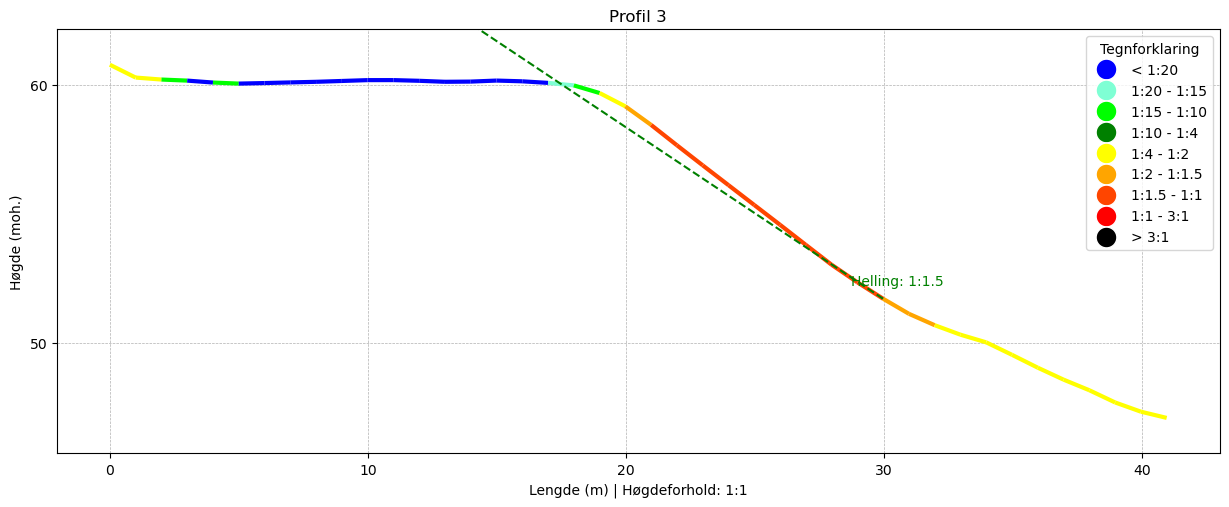

In [56]:
tittel = 'Profil 3'
farger = 'Stabilitet'  #Kan være 'Snøskred', 'Jordskred' eller 'Stabilitet'. Gir forskjellig fargeskala for bratthet langs profilet
featurenavn = 'Profil3'

'''Alt under her er tilleggsvalg som kan gi meir info på plott, sjå demo lenger ned'''
utjamning = False #Dersom ein vil forenkle profilet, f.eks ved bruk av veldig fin DTM kan ein få det på meterskala eller f.eks 10 meter per punkt
opplosning = 1
tiltak = False #Dersom ein vil plotte plassering av eit tiltak, kjem opp som kryss, skriv True om du vil ha det med
tiltak_plassering = 35 #Plasseringen av tiltaket, meterverdi langs profilet, høgde kjem automatisk
femtenlinje = True #Legger på ei linje langs profilet med fast helling
linjeverdi = 1/1.5  #Hellinga på linja
meterverdi = 30 #Start på linja
retning ='Mot venstre'  #retning på linje med helling
juster = 0 #Høgdejustering i forhold til profillinja
legend=True #Vise tegnforklaring eller ikkje, skriv False hvis ikkje
vannflate=False #Vise vannflate eller ikkje, gir ei horisontal linje på valgt kote
kote=44 #Kote på vannflate
vann_retning="Mot høgre" #Retning på horisontal strek

inputfc1 = gdb + '\\' + featurenavn
out_table1 = "temp_tabell" + str(time.time())[-4:]
df = profil(inputfc1, insurface1, out_table1)
df_plot = terrengprofil(df, utjamning, opplosning)
fargeplot(df_plot, ruteavstand_x, ruteavstand_y, farger, aspect, tiltak, tiltak_plassering, femtenlinje, linjeverdi, meterverdi, retning, juster, legend, vannflate, kote, vann_retning)
plt.title(tittel)
arcpy.management.Delete(gdb + '\\' + out_table1)

<Result 'true'>

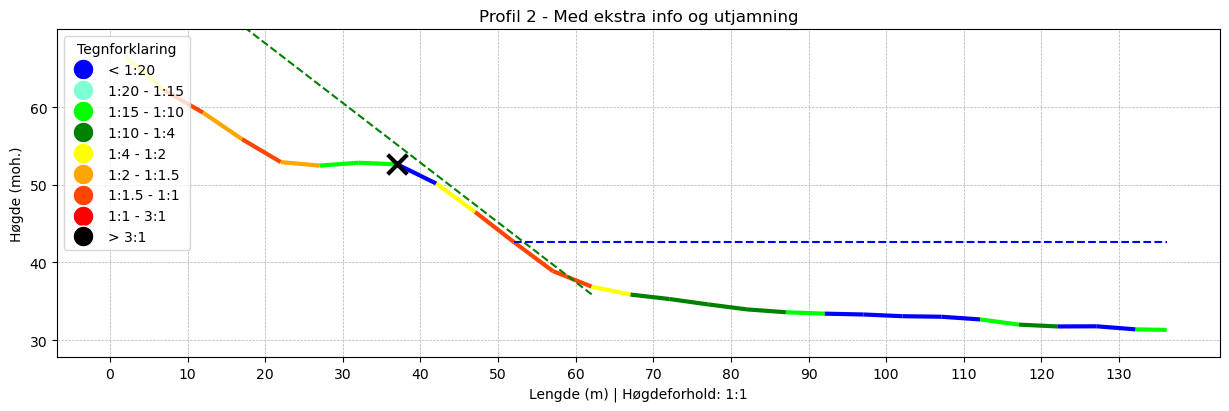

In [7]:
tittel = 'Profil 2 - Med ekstra info og utjamning'
farger = 'Stabilitet'  #Kan være 'Snøskred', 'Jordskred' eller 'Stabilitet'. Gir forskjellig fargeskala for bratthet langs profilet
featurenavn = 'Profil_Strekning1'

'''Alt under her er tilleggsvalg som kan gi meir info på plott, sjå demo lenger ned'''
utjamning = True #Dersom ein vil forenkle profilet, f.eks ved bruk av veldig fin DTM kan ein få det på meterskala eller f.eks 10 meter per punkt
opplosning = 5
tiltak = True #Dersom ein vil plotte plassering av eit tiltak, kjem opp som kryss, skriv True om du vil ha det med
tiltak_plassering = 35 #Plasseringen av tiltaket, meterverdi langs profilet, høgde kjem automatisk
femtenlinje = True #Legger på ei linje langs profilet med fast helling
linjeverdi = 1/1.3  #Hellinga på linja
meterverdi = 60 #Start på linja
retning ='Mot venstre'  #retning på linje med helling
juster = 1 #Høgdejustering i forhold til profillinja
legend=True #Vise tegnforklaring eller ikkje, skriv False hvis ikkje
vannflate=True #Vise vannflate eller ikkje, gir ei horisontal linje på valgt kote
kote=44 #Kote på vannflate
vann_retning="Mot høgre" #Retning på horisontal strek

inputfc1 = gdb + '\\' + featurenavn
out_table1 = "temp_tabell" + str(time.time())[-4:]
df = profil(inputfc1, insurface1, out_table1)
df_plot = terrengprofil(df, utjamning, opplosning)
fargeplot(df_plot, ruteavstand_x, ruteavstand_y, farger, aspect, tiltak, tiltak_plassering, femtenlinje, linjeverdi, meterverdi, retning, juster, legend, vannflate, kote, vann_retning)
plt.title(tittel)
arcpy.management.Delete(gdb + '\\' + out_table1)

# Setter opp generering av fleire profil uten helling
Litt anna forenkla metode, men meir fleksibel for å etablere fleire linjer, førebels uten å fargelegge profil

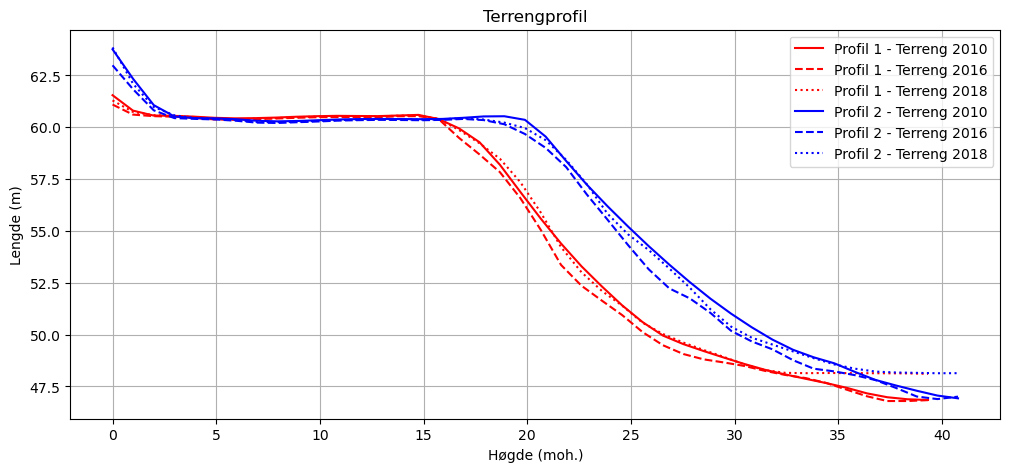

In [51]:
tittel = 'Terrengprofil'

xlabel = 'Høgde (moh.)'
ylabel = 'Lengde (m)'

#Gi kva feature du vil tegne langs
inputfc1 = gdb + '\Profil'
inputfc2 = gdb + '\Profil2'

#Gi kva terrengoverlfate du vil tegne topp
insurface3 = r'P:\GEO\GEOTEKNIKK\_Drift og vedlikehold\Fv559 Mylna\01 Grunnlag\Terrengmodell\NDH Voss 5pkt 2016\data\dtm\NDH Voss 5pkt 2016-32-1-478-150-07-dtm.tif'
insurface1 = r'P:\GEO\GEOTEKNIKK\_Drift og vedlikehold\Fv559 Mylna\01 Grunnlag\Terrengmodell\Voss Vaksdal 2010\data\dtm\Voss Vaksdal 2010-32-1-478-150-07-dtm.tif'
insurface2 = r'P:\GEO\GEOTEKNIKK\_Drift og vedlikehold\Fv559 Mylna\01 Grunnlag\Terrengmodell\NVE Vosso 5pkt 2018\data\dtm\NVE Vosso 5pkt 2018-dtm.tif'

# out_table1 = "temp_tabell" + str(time.time())[-4:]
# out_table2 = "temp_tabell" + str(time.time())[-3:]
# out_table3 = "temp_tabell" + str(time.time())[-3:]
df1 = profil(inputfc1, insurface1, "temp_tabell" + str(time.time())[-4:])
df2 = profil(inputfc1, insurface2, "temp_tabell" + str(time.time())[-4:])
df3 = profil(inputfc1, insurface3, "temp_tabell" + str(time.time())[-4:])
df4 = profil(inputfc2, insurface1, "temp_tabell" + str(time.time())[-4:])
df5 = profil(inputfc2, insurface2, "temp_tabell" + str(time.time())[-4:])
df6 = profil(inputfc2, insurface3, "temp_tabell" + str(time.time())[-4:])
plt.figure(figsize=(12, 8))
plt.plot(df1['M'], df1['Z'], color='r', linestyle='solid', label='Profil 1 - Terreng 2010')
plt.plot(df2['M'], df2['Z'], color='r', linestyle='dashed', label='Profil 1 - Terreng 2016')
plt.plot(df3['M'], df3['Z'], color='r', linestyle='dotted', label='Profil 1 - Terreng 2018')
plt.plot(df4['M'], df4['Z'], color='b', linestyle='solid', label='Profil 2 - Terreng 2010')
plt.plot(df5['M'], df5['Z'], color='b', linestyle='dashed', label='Profil 2 - Terreng 2016')
plt.plot(df6['M'], df6['Z'], color='b', linestyle='dotted', label='Profil 2 - Terreng 2018')
plt.title(tittel)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# Eksport av profil til dxf
Krever innstallasjon av pakken ezdxf

In [9]:
import ezdxf
def export_to_dxf(df, filename):
    doc = ezdxf.new("R2010")  # Opprett en ny DXF-dokumentobjekt

    msp = doc.modelspace()  # Hent modellområdet

    # Hent koordinatene fra DataFrame og opprett linjer
    coordinates = df[['M', 'Z']].values.tolist()
    for i in range(len(coordinates) - 1):
        start = coordinates[i]
        end = coordinates[i + 1]
        msp.add_line(start, end)

    doc.saveas(filename)  # Lagre DXF-filen


In [10]:

filename = r'C:\Users\janaal\Documents\ArcGIS\Projects\Voss\koordinater.dxf'

export_to_dxf(df3, filename)


In [11]:
#Dummy

def plot_terrenglinje(tittel, inputfc, insurface, gdb):
    
    inputfc1 = gdb2 + '\\' + inputfc

    out_table1 = "temp_tabell" + str(time.time())[-4:]
    df1 = profil(inputfc1, insurface1, out_table1)
    df1['L'] = (df1['M'] * (1/15)) + df1['Z'][0]



    plt.figure(figsize=(20, 8))
    plt.plot(df1['M'], df1['Z'], label='Terreng')
    plt.plot(df1['M'], df1['L'], label='1:15 linje')
    plt.title(tittel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_aspect(2)
    plt.show()
    arcpy.Delete_management(out_table1)

In [12]:
plot_terrenglinje('Terregprofil 6', 'Terrrengprofil6',insurface1, gdb2)

NameError: name 'gdb2' is not defined

In [ ]:
##Dummy
def profil2(inputfc, terreng, tempfc_punkter):
     '''Funksjonen lager pandas dataframe fra ein feature i ein arcgis geodatabase'''
    self.inputfc = inputfc
    self.terreng = terreng
    self.tempfc_punkter = tempfc_punkter
    #Langer punkt kvar 1 meter langs input profil
    arcpy.GeneratePointsAlongLines_management(inputfc, tempfc_punkter, 'DISTANCE',
                                        Distance='1 Meters')
    #Legger z koordinater på punkter ut frå valt raster surface
    arcpy.ddd.AddSurfaceInformation(tempfc_punkter, terreng, 'Z', 'BILINEAR')
    #Tar ut koordinatlister frå puntkter feature class 
    with arcpy.da.SearchCursor(tempfc_punkter, ["SHAPE", 'Z']) as cursor:
        x_list = []
        y_list = []
        z_list = []
        for row in cursor:
            x, y = row[0]
            x_list.append(x)
            y_list.append(y)
            z_list.append(row[1])
        #Etablerer Pandas dataframe for forenkling av vidare databehandling
    self.df = pd.DataFrame(list(zip(x_list, y_list, z_list)), columns =['X', 'Y', 'Z'])

    #Regner ut distanse mellom punkter (muligens unødvening, kan kanskje bruke index
    #til punkter istadenfor? Sidan kvar punkt er etalbert per meter?.
    self.df['DIST'] = np.sqrt(((self.df.X - self.df.X.shift(1))**2)+((self.df.Y - self.df.Y.shift(1))**2))
    self.df['M'] = self.df.DIST + self.df.DIST.shift(1)
    self.df.loc[0, 'M'] = 0
    self.df.loc[0, 'DIST'] = 0
    self.df.loc[1, 'M'] = self.df.loc[1, 'DIST']
    self.df.loc[0, 'H'] = 0
        
    #Regner ut lengden basert på avstand mellom punkter
    for i in range(2, len(self.df)):
        self.df.loc[i, 'M'] = self.df.loc[i-1, 'DIST'] + self.df.loc[i-1, 'M']

    #Runder av meterverdien 
    self.df['M'] = self.df['M'].round(0)